In [1]:
import os
import sys
sys.path.append("../../NephNet")
import argparse
import torch
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from train import get_instance
import numpy as np
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
from torch.optim import lr_scheduler
from tqdm import tqdm
import math
from utils import util
import pandas as pd
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from torch.utils.data import Dataset, DataLoader
from utils import transforms3d as t3d
import h5py
import re
import pandas as pd
from skimage import io, transform

print("Modules loaded")

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Modules loaded


In [2]:
print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


#Create a data loader for F59
config_text = "C:/Users/awoloshu/Documents/NephNet/configs/config_Train33Test44.json"
with open(config_text) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

torch.backends.cudnn.benchmark = True
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["NUMEXPR_MAX_THREADS"] = "16"
print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
train_logger = Logger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setup data_loader instances
data_loader = get_instance(module_data, 'data_loader', config)
valid_data_loader = data_loader.split_validation()

if torch.cuda.is_available():
    print("Using GPU: " + torch.cuda.get_device_name(0))
else:
    print("Using CPU to train")

GPUs available: 1
GPUs available: 1
Using GPU: GeForce RTX 2080 Ti


In [3]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

class hdf5dataset(Dataset):
    '''
    Reads an HDF5 file with the following keys: train_data, train_labels, test_data, test_labels, test_ids. Train_data is a vector which is reshped to fit the shape variable. Works for both 2D and 3D input
    '''
    def __init__(self, h5_path, shape = (7,32,32), training = True, transforms=None, projection = False):
        st = pd.HDFStore(h5_path)
        self.store = st
        if training:
            self.data = st['train_data'].values
            self.label = st['train_labels'].values.squeeze()
        else:
            self.data = st['test_data'].values
            self.label = st['test_labels'].values.squeeze()
        self.transforms = transforms
        self.data_len = self.data.shape[0]
        self.shape = shape
        self.projection = projection
        #print(type(self.data))
        # weight the classes by 1/#examples * maximum #examples, note that labels should start at 1
        # for example if the number of examples = [10, 50, 100] then self.weight = [10, 2, 1]
        count_labels = {}
        for item in self.label:
            if item: 
                key = "class_" + str(item)
                if not key in count_labels: count_labels[key] = 0
                count_labels[key] += 1 
        weights = []
        weights2 = []
        mysort = []
        for key in count_labels:
            mysort.append(key)
        mysort.sort(key = natural_keys)
        
        for key in mysort:
            weights.append(1. / count_labels[key])
            weights2.append(count_labels[key])
        
        weightsnp = np.asarray(weights)
        weights2np = np.asarray(weights2)
        maxnum = np.amax(weights2np)
        weightsnp = weightsnp*maxnum
        self.weight = torch.FloatTensor(weightsnp)
            
    def getIds(self):
        #get test serial ID for mapping back to the original image. 
        #NOTE: IDs should NOT be shuffled in order to keep ground truth label with the correct ID
        ids = self.store['test_ids'].values
        return ids
    
    def __getitem__(self, index):
        num_pixels = 1
        for dim in self.shape: num_pixels = num_pixels*dim
        #print(len(self.data))
        #print(num_pixels)
        #print(type(self.data))
        img = self.data[index, 0:num_pixels]
        img = np.reshape(img, self.shape, order = 'C') #last index of shape changes fastest
        img = img.astype(float)
        img = np.float32(img)
        #print(str(np.amin(img)))
        '''
        if self.projection:
            img = np.amax(img, axis = 0)
        '''
        label = self.label[index] - 1 #labeling starts at 0 for CNN
        
        # Perform augmentation. The data loader differentiates between training and test transformations, this simply sends the batch to receive the transformations
        if self.transforms is not None:
            if len(self.shape) > 2 and not self.projection: #3D input
                for transform in self.transforms:
                    img = transform(img)
                img_as_tensor = img
        return img_as_tensor, label

    def __len__(self):
        return self.data_len
    
rs = np.random.RandomState()    
trsfm_train = [#t3d.shotNoise(rs, alpha = 0.8, execution_prob = 0.2), 
                       #t3d.Downsample(rs, factor = 2.1, order=2),
                       t3d.RandomFlip(rs),
                       t3d.RandomRotate90(rs),
                       t3d.RandomRotate(rs, angle_spectrum=25, axes=[(1,2)], mode='constant', order=1),
                       t3d.Translate(rs, pixels = 5, execution_prob = 1),
                       t3d.RandomContrast(rs, factor = 0.8, execution_probability=1), 
                       #t3d.ElasticDeformation(rs, 3, alpha=20, sigma=3, execution_probability=0.2), 
                       #t3d.GaussianNoise(rs, 3), 
                       t3d.Normalize(config['data_loader']['args']['mean'], config['data_loader']['args']['stdev']), 
                       t3d.ToTensor(True)]
        
trsfm_test = [#t3d.Normalize(config['data_loader']['args']['mean'], config['data_loader']['args']['stdev']), 
                      t3d.ToTensor(True)]

transformed_dataset = hdf5dataset(config['data_loader']['args']['hdf5_path'], transforms = trsfm_train)
normal_dataset = hdf5dataset(config['data_loader']['args']['hdf5_path'], transforms = trsfm_test)

print("CREATED BOTH DATASETS")

CREATED BOTH DATASETS


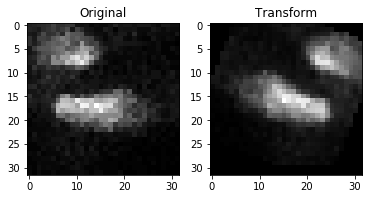

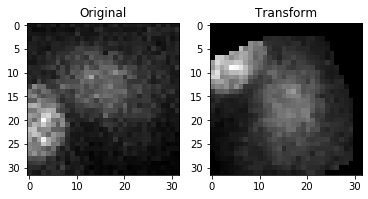

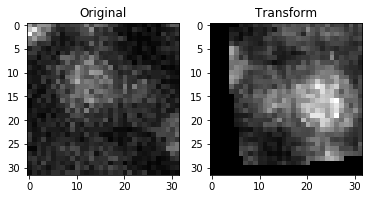

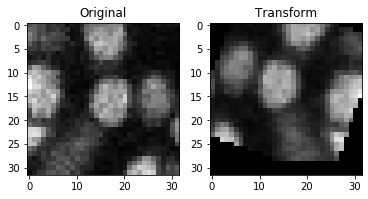

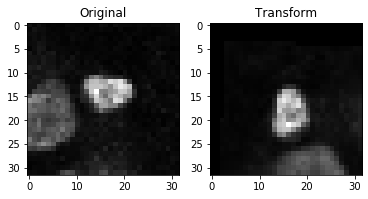

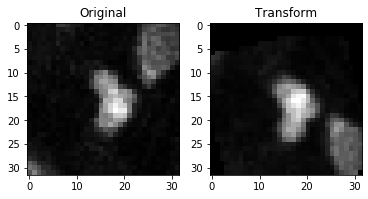

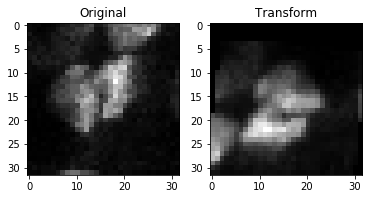

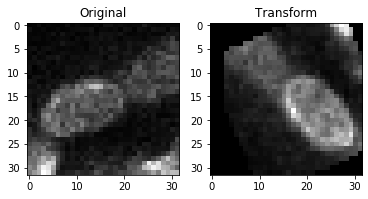

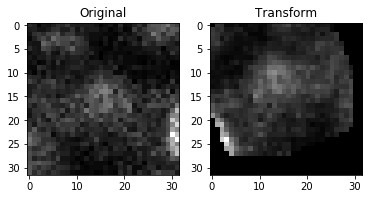

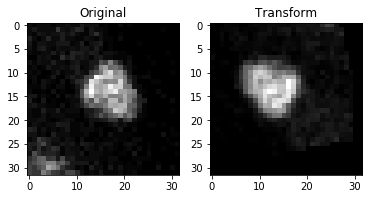

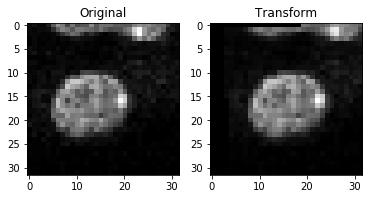

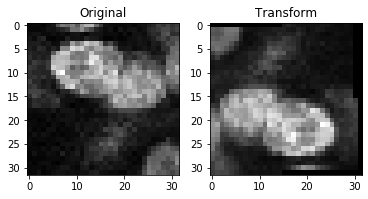

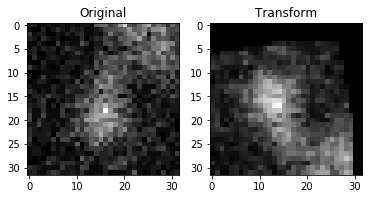

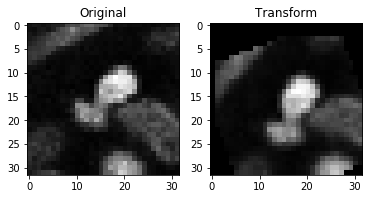

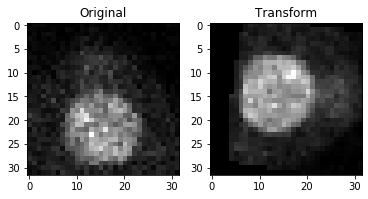

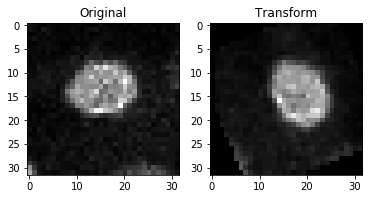

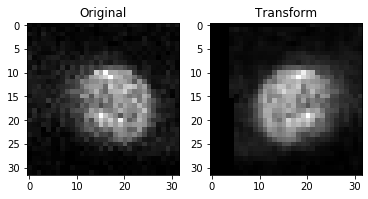

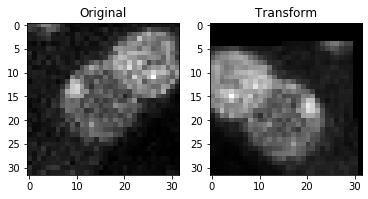

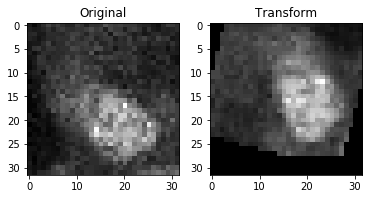

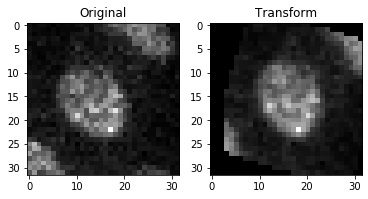

In [4]:
num_images = 20

idxs = np.random.choice(len(transformed_dataset), num_images)

for i, idx in enumerate(idxs):
    img_t = np.squeeze(transformed_dataset.__getitem__(idx)[0].cpu().numpy())
    img_o = np.squeeze(normal_dataset.__getitem__(idx)[0].cpu().numpy())
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(img_o[3], cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(img_t[3], cmap='gray')
    axs[1].set_title("Transform")
    plt.pause(0.1)
    plt.show()
    

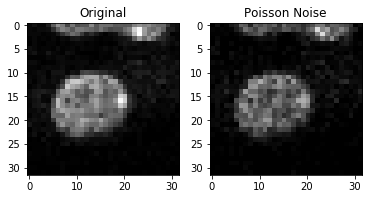

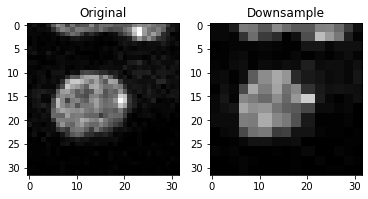

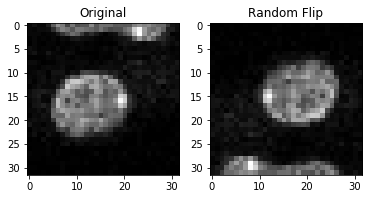

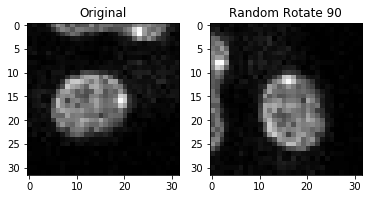

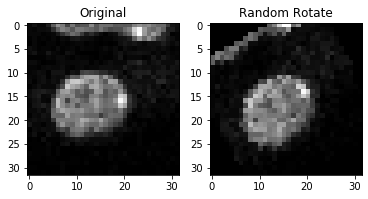

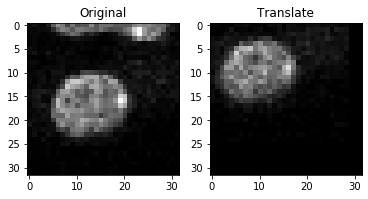

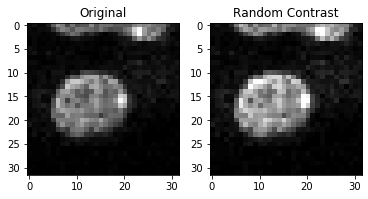

In [13]:
trsfm_2show = [t3d.shotNoise(rs, alpha = 0.8, execution_prob = 1.0), 
                       t3d.Downsample(rs, factor = 2.1, order=0, execution_prob = 1.0),
                       t3d.RandomFlip(rs, execution_prob = 1.0),
                       t3d.RandomRotate90(rs),
                       t3d.RandomRotate(rs, angle_spectrum=35, axes=[(1,2)], mode='constant', order=0),
                       t3d.Translate(rs, pixels = 8, execution_prob = 1.0),
                       t3d.RandomContrast(rs, factor = 0.1, execution_probability=1.0), 
                       #t3d.ElasticDeformation(rs, 3, alpha=20, sigma=3, execution_probability=0.2), 
                       #t3d.GaussianNoise(rs, 3), 
                       #t3d.Normalize(config['data_loader']['args']['mean'], config['data_loader']['args']['stdev']), 
                       #t3d.ToTensor(True)
              ]
transform_names = ["Poisson Noise", "Downsample", "Random Flip", "Random Rotate 90", "Random Rotate", "Translate", "Random Contrast"]
idx = idxs[10]
for i,func in enumerate(trsfm_2show):
    img_o = np.squeeze(normal_dataset.__getitem__(idx)[0].cpu().numpy())
    vmi = np.amin(img_o[3])
    vma = np.amax(img_o[3])
    output = func(img_o)
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(img_o[3], cmap='gray', vmin = vmi, vmax = vma)
    axs[0].set_title("Original")
    axs[1].imshow(output[3], cmap='gray', vmin = vmi, vmax = vma)
    title_str = transform_names[i]
    axs[1].set_title(title_str)
    plt.pause(0.1)
    plt.show()
    